# Determining Sigma 10, Sigma 20 & R 10, R 20 of DESIJ0215-2909

Author(s): Nusrath Jahan, Anowar Shajib, S M Rafee Adnan

## Load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

In [2]:
data, header = fits.getdata("./DESIJ0215-2909_F140W_drz_sci.fits", header=True)

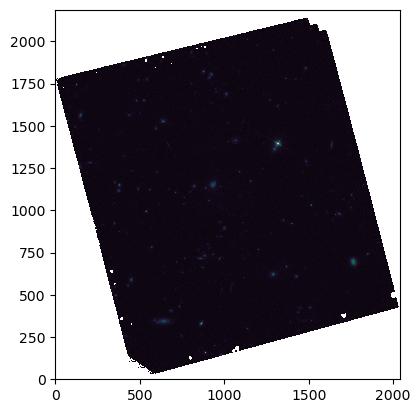

In [3]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

In [4]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

/var/folders/k8/sj0v8p9j6mq0ks525cj30mzm0000gn/T/ipykernel_58965/1236197877.py:2: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


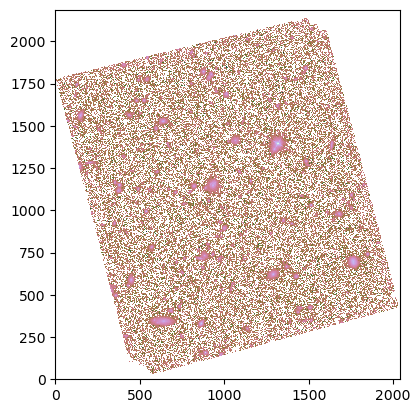

In [5]:
plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [6]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.31832204500101835, 0.013773692784527596)

In [7]:
bkg_subtracted_data = data - bkg.background

In [8]:
threshold = 4 * bkg.background_rms

In [9]:
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [10]:
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

In [11]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (2188, 2039)
nlabels: 588
labels: [  1   2   3   4   5 ... 584 585 586 587 588]


In [12]:
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.catalog.SourceCatalog>
Length: 588
labels: [  1   2   3   4   5 ... 584 585 586 587 588]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region near your lensing system

In [13]:
set_x_lim1, set_x_lim2 = 700, 1150
set_y_lim1, set_y_lim2 = 900, 1400

/var/folders/k8/sj0v8p9j6mq0ks525cj30mzm0000gn/T/ipykernel_58965/2987252737.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


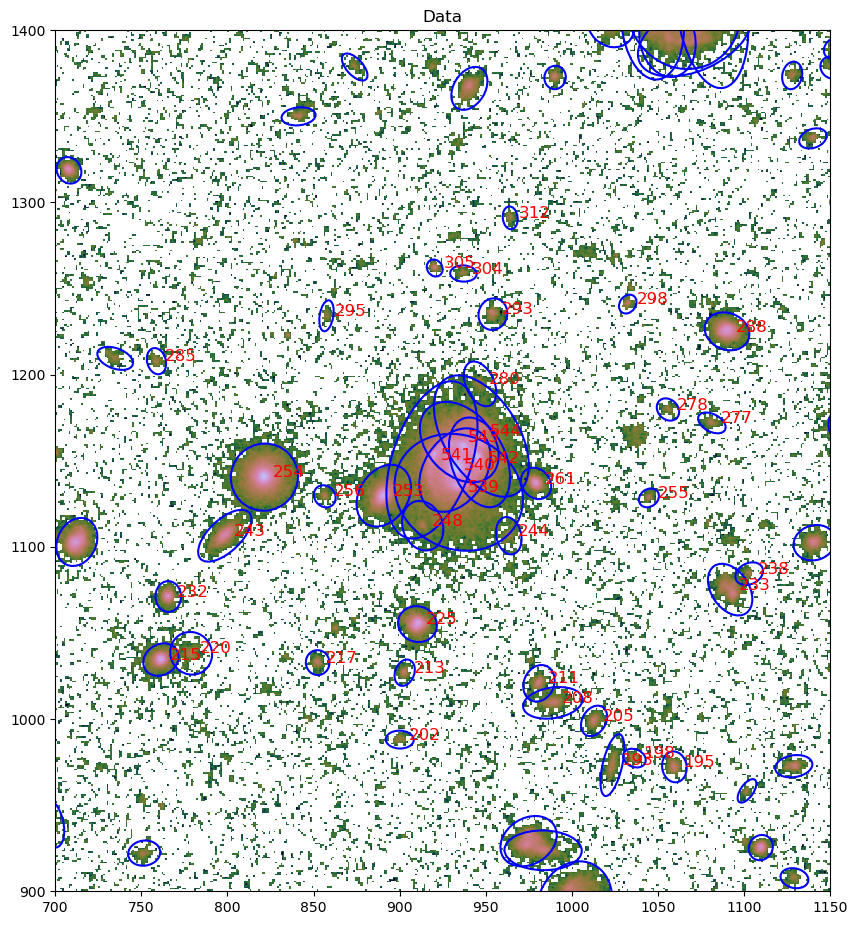

In [14]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[540]) < 180
        and np.abs(cat.ycentroid[i] - cat.ycentroid[540]) < 180
    ):
        ax1.text(
            cat.xcentroid[i] + 5,
            cat.ycentroid[i],
            f"{i}",
            c="r",
            fontsize=12
            # transform=ax1.transAxes
        )
# cat.plot_kron_apertures(ax=ax1, color='white', lw=1.5);

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Determine the central deflector's ID

/var/folders/k8/sj0v8p9j6mq0ks525cj30mzm0000gn/T/ipykernel_58965/3090931970.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


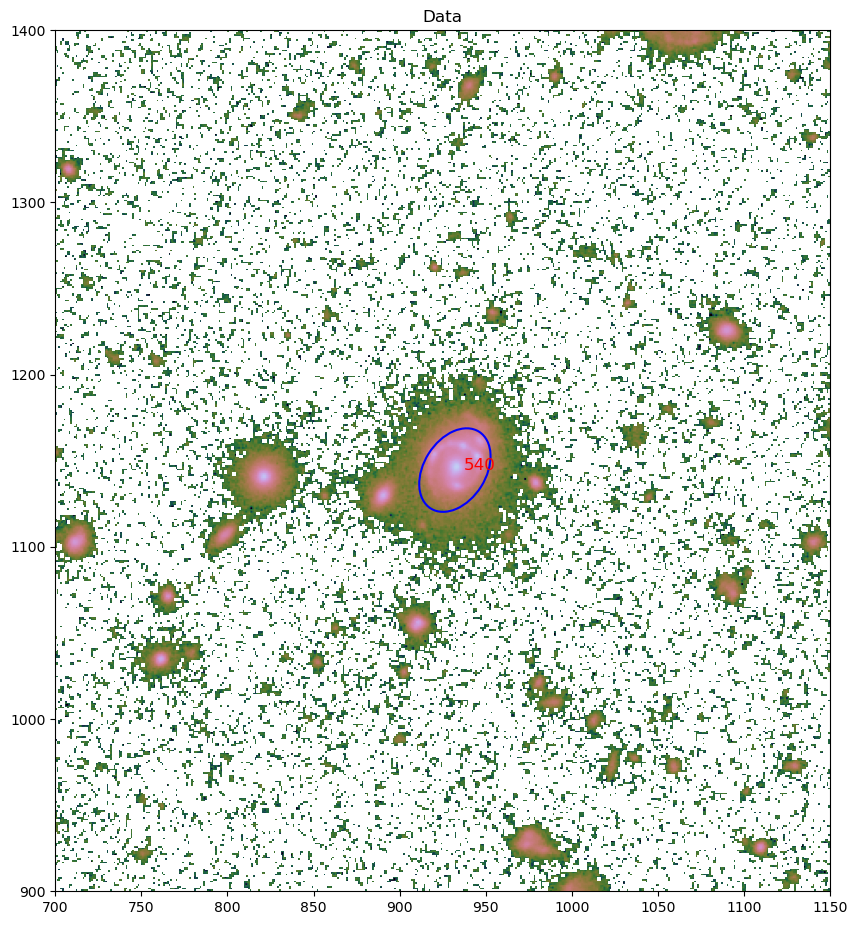

In [15]:
# object id of your central deflector/lens
id_central = 540

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12
    # transform=ax1.transAxes
)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [16]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating List of neighbouring Galaxies

In [17]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of all close galaxies within 20 arcsecond radius:", len(close_galaxies_all)
)

Number of all close galaxies within 20 arcsecond radius: 50


In [18]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of close galaxies excluding dim sources within 20 arcsecond radius:",
    len(close_galaxies_1),
)

Number of close galaxies excluding dim sources within 20 arcsecond radius: 32


In [19]:
def distance_arcsec(pixel_distance):
    """
    Convert distance from unit of pixels into arcsec unit.

         :param pixel_distance: distance in unit of pixels
         :return: distance in arcsec unit
    """
    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

In [20]:
remove_list = [
    540,  # Central Deflector
    539,  # Central Deflector
    541,  # lensed arc
    542,  # lensed arc
    543,  # lensed arc
    544,  # lensed arc
]  # list of galaxies you want to be removed

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
248         37.335958          2.986877   17.407662    0.787854
253         43.888838          3.511107  108.766054    0.735257
261         47.765238          3.821219   27.014060    0.827676
244         49.299038          3.943923    6.149716    0.656712
280         52.132461          4.170597    7.383340    0.592768
256         77.082668          6.166613    3.160074    0.865177
225         92.038674          7.363094   62.809333    0.904009
293         93.200487          7.456039    6.248890    0.896858
254        110.686694          8.854936  209.860834    0.983032
255        113.829602          9.106368    2.399646    0.809171
304        114.243942          9.139515    2.027332    0.611517
295        116.556230          9.324498    1.660257    0.437045
305        117.912118          9.432969    3.409737    0.849730
213        121.199289          9.695943    4.113972    0.705143
278        128.620821         10.289666 

In [21]:
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
248         37.335958          2.986877   17.407662    0.787854
253         43.888838          3.511107  108.766054    0.735257
261         47.765238          3.821219   27.014060    0.827676
244         49.299038          3.943923    6.149716    0.656712
280         52.132461          4.170597    7.383340    0.592768
225         92.038674          7.363094   62.809333    0.904009
293         93.200487          7.456039    6.248890    0.896858
254        110.686694          8.854936  209.860834    0.983032
211        133.088020         10.647042    9.491942    0.797383
243        138.912732         11.113019   36.875140    0.480275
208        146.637083         11.730967   12.456071    0.512055
205        166.558359         13.324669    6.938395    0.719878
233        174.244092         13.939527   22.221573    0.655993
288        177.370944         14.189676   62.668680    0.797097
232        181.906551         14.552524 

## Determining Sigma 10, 20 and R 10, 20

/var/folders/k8/sj0v8p9j6mq0ks525cj30mzm0000gn/T/ipykernel_58965/2229957270.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/var/folders/k8/sj0v8p9j6mq0ks525cj30mzm0000gn/T/ipykernel_58965/2229957270.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/var/folders/k8/sj0v8p9j6mq0ks525cj30mzm0000gn/T/ipykernel_58965/2229957270.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/var/folders/k8/sj0v8p9j6mq0ks525cj30mzm0000gn/T/ipykernel_58965/2229957270.py:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2



EXCLUDING DIM SOURCES
R 10: 11.113018522753272
R 20: 17.146428958921565
Sigma 10: 0.025774250842228418
Sigma 20: 0.021653731835851106

FOR All SOURCES
R 10: 9.10636812008749
R 20: 11.73096661873523
Sigma 10: 0.038384838915819126
Sigma 20: 0.04626073461298758


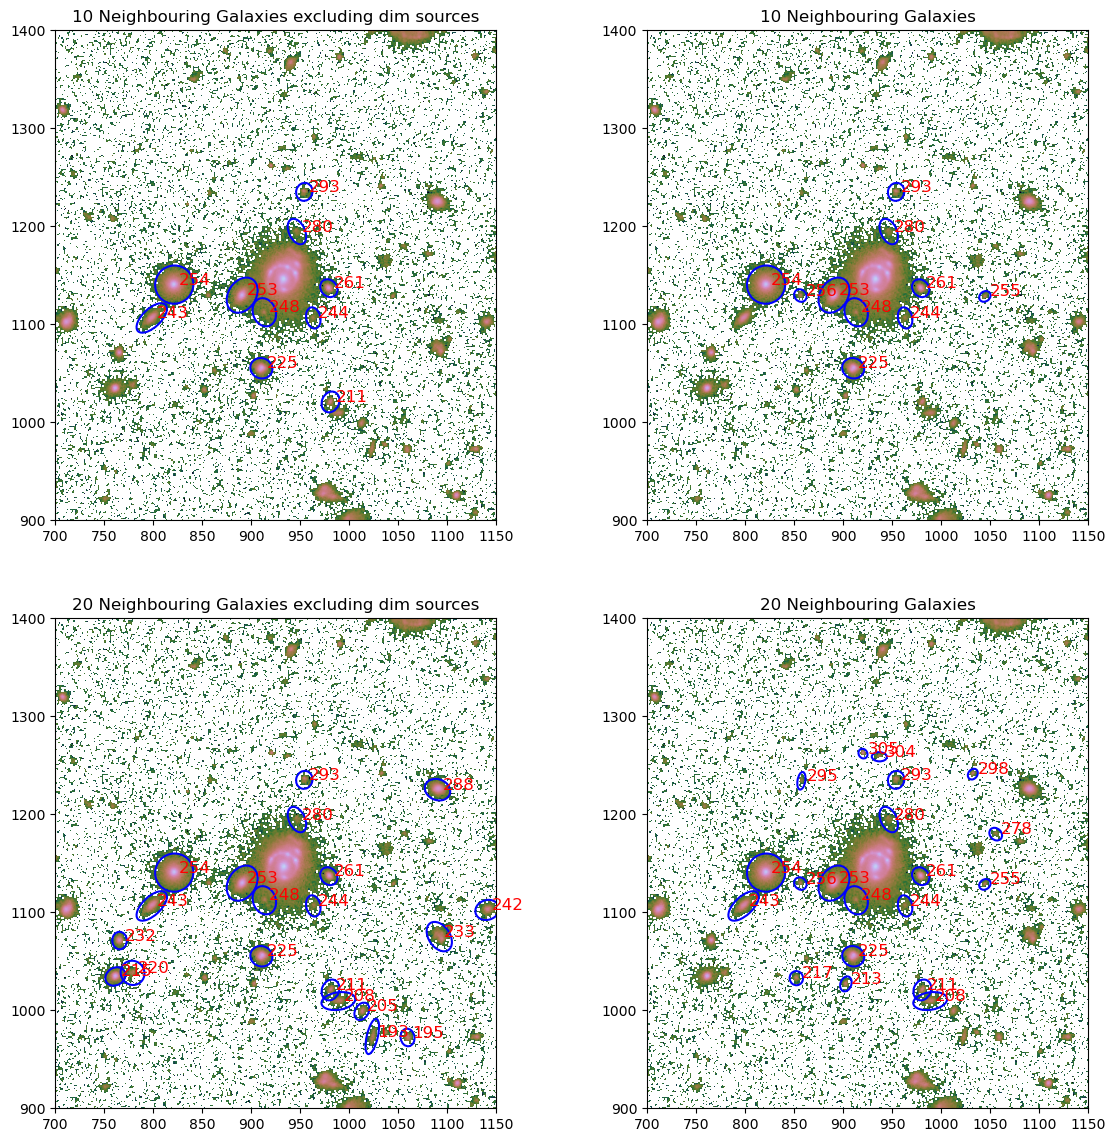

In [22]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighbouring Galaxies")
axs[1, 0].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

R_10_1 = df_1_20.iloc[
    9, df_1_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
R_20_1 = df_1_20.iloc[
    19, df_1_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

R_10_all = df_all_20.iloc[
    9, df_all_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
R_20_all = df_all_20.iloc[
    19, df_all_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)